In [45]:
import numpy as np
import sklearn.neighbors
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

import butterflies
from dwt_transform import DWT2Numpy
from network import Net, run

device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
import matplotlib.pyplot as plt

def get_epoch_info_from_file(file):
    epochs = []
    accuracies = []
    test_losses = []
    with open(file, "r") as f:
        for line in f.readlines():
            line = line.lower()
            if "epoch" in line:
                _, epoch_num = line.split()
                epochs.append(epoch_num)
            if "accuracy" in line:
                _, accuracy_raw, _, _, loss_raw = line.split()
                accuracy = float(accuracy_raw.strip("%,"))
                loss_val = float(loss_raw)
                accuracies.append(accuracy)
                test_losses.append(loss_val)
    return epochs, (accuracies, test_losses)
                
def _get_fig_ax(fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = fig.gca()
    if ax is None:
        ax = fig.gca()
    return fig, ax

def plot_file(file, label, fig=None, ax=None):
    fig, ax = _get_fig_ax(fig, ax)
    epochs, (accuracy, _) = get_epoch_info_from_file(file)
    ax.plot(epochs, accuracy, label=label)
    return fig, ax

def plot_epoch_info(original_file, wav_files, dataset_str, wav_strs):
    fig, ax = plot_file(original_file, dataset_str)
    for wav_label, file in zip(wav_strs, wav_files):
        plot_file(file, dataset_str + ": " + wav_label, fig=fig, ax=ax)
    fig.legend(loc="center right")
    return fig, ax

In [47]:
transform_dwt = transforms.Compose([DWT2Numpy("haar"), transforms.ToTensor()])

train_data_dwt = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform_dwt)
val_data_dwt = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform_dwt)
test_data_dwt = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform_dwt)

batch_size = 64
train_loader_dwt = DataLoader(
    train_data_dwt, batch_size=batch_size, shuffle=True, num_workers=4#, pin_memory=True
)
val_loader_dwt = DataLoader(
    val_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)
test_loader_dwt = DataLoader(
    test_data_dwt, batch_size=batch_size, shuffle=False, num_workers=2#, pin_memory=True
)


In [48]:
transform = transforms.ToTensor()

train_data = butterflies.ButterflyDataset("../data", datasplit="train", transform=transform)
val_data = butterflies.ButterflyDataset("../data", datasplit="valid", transform=transform)
test_data = butterflies.ButterflyDataset("../data", datasplit="test", transform=transform)

batch_size = 64
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

In [49]:
knn5 = sklearn.neighbors.KNeighborsClassifier()
knn10 = sklearn.neighbors.KNeighborsClassifier(10)
knn20 = sklearn.neighbors.KNeighborsClassifier(20)


def X_y_from_data(dataset):
    X_ys = [sample for sample in dataset]
    Xs, ys = tuple(zip(*X_ys))
    del X_ys
    X = np.concatenate(
        [x.detach().cpu().numpy().flatten()[None, ...] for x in Xs],
        axis=0,
    )
    y = np.array(ys)
    del Xs, ys
    # print(X.shape, y.shape)
    return X, y

X, y = X_y_from_data(train_data)
knn5.fit(X, y)
knn10.fit(X, y)
knn20.fit(X, y)
X_test, y_test = X_y_from_data(test_data)
print(f"KNN5 score: {knn5.score(X_test, y_test)}")
print(f"KNN10 score: {knn10.score(X_test, y_test)}")
print(f"KNN20 score: {knn20.score(X_test, y_test)}")
del X, y
del X_test, y_test


KNN5 score: 0.178
KNN10 score: 0.172
KNN20 score: 0.168


In [50]:
loss_fn = torch.nn.NLLLoss()

In [51]:
net = Net(
    conv_layers=((12, 5), (32, 5), (64, 5), (128, 3)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, dampening=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
net_dwt = Net(
    conv_layers=((32, 5), (64, 5), (128, 3)),
    linear_layers=(512, 256),
    output_size=len(train_data.classes),
    output_activation=lambda x: torch.log_softmax(x, dim=1),
)
# net_dwt = Net(
#     conv_layers=(),
#     linear_layers=(1024,),
#     output_size=len(train_data.classes),
#     output_activation=torch.sigmoid,
# )
net_dwt.to(device)
# optimizer_dwt = optim.SGD(net_dwt.parameters(), lr=0.01, momentum=0.9, dampening=0.1)
optimizer_dwt = optim.Adam(net_dwt.parameters(), lr=0.001)

In [53]:
%%capture out_normal
run(train_loader, val_loader, net, loss_fn, optimizer, device, 50)

In [54]:
out_normal()
%store out_normal.stdout >../result/Butterfly_original.txt

Epoch 1
-------------------------------
loss: 4.602232  [    0/12639]
loss: 4.608751  [ 1216/12639]
loss: 4.599837  [ 2432/12639]
loss: 4.573211  [ 3648/12639]
loss: 4.154710  [ 4864/12639]
loss: 4.169452  [ 6080/12639]
loss: 4.279185  [ 7296/12639]
loss: 4.098464  [ 8512/12639]
loss: 3.948715  [ 9728/12639]
loss: 3.810149  [10944/12639]
loss: 3.613313  [12160/12639]
Test Error: 
 Accuracy: 14.8%, Avg loss: 3.593448 

Epoch 2
-------------------------------
loss: 3.745396  [    0/12639]
loss: 3.480247  [ 1216/12639]
loss: 3.491927  [ 2432/12639]
loss: 3.173898  [ 3648/12639]
loss: 2.879150  [ 4864/12639]
loss: 3.004544  [ 6080/12639]
loss: 3.015072  [ 7296/12639]
loss: 2.530770  [ 8512/12639]
loss: 2.775006  [ 9728/12639]
loss: 2.686395  [10944/12639]
loss: 2.683443  [12160/12639]
Test Error: 
 Accuracy: 40.2%, Avg loss: 2.262126 

Epoch 3
-------------------------------
loss: 2.112514  [    0/12639]
loss: 2.588331  [ 1216/12639]
loss: 2.344451  [ 2432/12639]
loss: 2.109920  [ 3648/126

In [55]:
%%capture out_dwt
run(train_loader_dwt, val_loader_dwt, net_dwt, loss_fn, optimizer_dwt, device, 50)

In [56]:
out_dwt()
%store out_dwt.stdout >../result/Butterfly_haar.txt

Epoch 1
-------------------------------
loss: 5.559098  [    0/12639]
loss: 4.602271  [ 1216/12639]
loss: 4.384833  [ 2432/12639]
loss: 4.108358  [ 3648/12639]
loss: 3.824264  [ 4864/12639]
loss: 3.208412  [ 6080/12639]
loss: 2.777303  [ 7296/12639]
loss: 2.946479  [ 8512/12639]
loss: 2.789339  [ 9728/12639]
loss: 2.896094  [10944/12639]
loss: 2.389404  [12160/12639]
Test Error: 
 Accuracy: 42.8%, Avg loss: 2.220541 

Epoch 2
-------------------------------
loss: 2.485489  [    0/12639]
loss: 2.130354  [ 1216/12639]
loss: 2.536814  [ 2432/12639]
loss: 2.021686  [ 3648/12639]
loss: 1.924843  [ 4864/12639]
loss: 1.983026  [ 6080/12639]
loss: 1.702253  [ 7296/12639]
loss: 1.593956  [ 8512/12639]
loss: 1.754798  [ 9728/12639]
loss: 1.512870  [10944/12639]
loss: 1.669145  [12160/12639]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.617014 

Epoch 3
-------------------------------
loss: 1.433942  [    0/12639]
loss: 1.211159  [ 1216/12639]
loss: 1.057109  [ 2432/12639]
loss: 1.632706  [ 3648/126

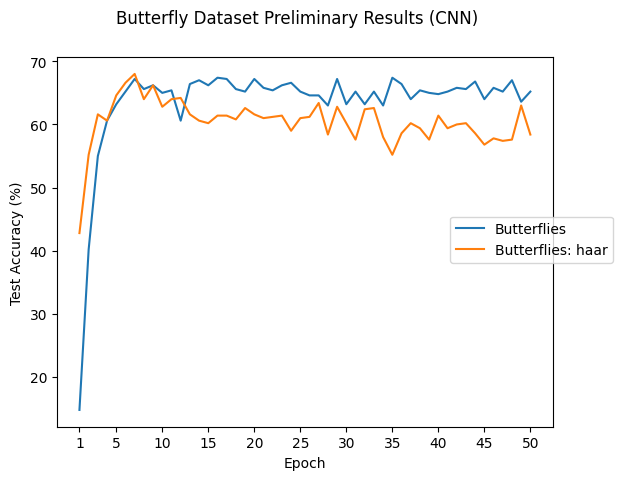

In [60]:
fig, ax = plot_epoch_info("../result/Butterfly_original.txt", ["../result/Butterfly_haar.txt"], "Butterflies", ["haar"])
ax.set_xticks([0] + [5*i - 1 for i in range(1, 11)])
ax.set_ylabel("Test Accuracy (%)")
ax.set_xlabel("Epoch")
fig.suptitle("Butterfly Dataset Preliminary Results (CNN)")
plt.show()